In [1]:
# !pip install pandas 
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
# !pip install seaborn
# !pip install tensorflow
# !pip install keras

ERROR: Could not find a version that satisfies the requirement tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow) (from versions: 0.0.1, 2.10.0.dev20220728, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow)


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
from tqdm import tqdm
import copy

In [3]:
# Create documents dataframe
dp_docs = [file for file in os.listdir('dependency_treebank/') if file.endswith('.dp')]
dataframes = []

for file in tqdm(dp_docs):
    with open('dependency_treebank/' + file, 'r') as f:
        lines = f.readlines()
        data = [line.split('\t') for line in lines]
        df = pd.DataFrame(data, columns=['word', 'pos', 'head'])
        # drop the last column
        df = df.iloc[:, :-1]
        dataframes.append(df)

df = pd.DataFrame({'Dataframes': dataframes})
print(df.head(5))
print(df['Dataframes'][0][0:5])
print(df.shape)

  2%|▏         | 4/199 [00:00<00:05, 38.80it/s]

100%|██████████| 199/199 [00:04<00:00, 44.20it/s]

                                          Dataframes
0              word   pos
0         Pierre   NNP
...
1              word  pos
0        Rudolph  NNP
1 ...
2           word   pos
0           A    DT
1     ...
3               word  pos
0          Yields  NNS
...
4                 word   pos
0              J.P. ...
     word  pos
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS
(199, 1)


In [93]:
# Split the dataframes into train, validation and test sets
train = df['Dataframes'][0:100]
val = df['Dataframes'][100:150]
test = df['Dataframes'][150:200]

print(train.shape)
print(val.shape)
print(test.shape)

(100,)
(50,)
(49,)


In [94]:
# Text preprocessing
def to_lower_case(df, docs):
    for i in range(docs, docs + len(df)):
        df[i]['word'] = df[i]['word'].str.lower()

to_lower_case(train, 0)
to_lower_case(val, 100)
to_lower_case(test, 150)
print(train[0][0:5])

           word  pos
0             a   DT
1     licensing   NN
2       company   NN
3  representing  VBG
4           the   DT


In [95]:
# Text preprocessing: from each doc remove newlines and empty lines
def remove_newlines(df, docs):
    for i in range(docs, docs + len(df)):
        df[i] = df[i][df[i]['word'] != '\n']
        df[i] = df[i][df[i]['word'] != '']

remove_newlines(train, 0)
remove_newlines(val, 100)
remove_newlines(test, 150)
print(train[0])
print(len(train[0]))
print(len(val[100]))
print(len(test[150]))

            word  pos
0         pierre  NNP
1         vinken  NNP
2              ,    ,
3             61   CD
4          years  NNS
5            old   JJ
6              ,    ,
7           will   MD
8           join   VB
9            the   DT
10         board   NN
11            as   IN
12             a   DT
13  nonexecutive   JJ
14      director   NN
15          nov.  NNP
16            29   CD
17             .    .
19           mr.  NNP
20        vinken  NNP
21            is  VBZ
22      chairman   NN
23            of   IN
24      elsevier  NNP
25          n.v.  NNP
26             ,    ,
27           the   DT
28         dutch  NNP
29    publishing  VBG
30         group   NN
31             .    .
31
827
220


In [97]:
# Create new dataframe that contains the single sentences
def create_sentences(df, docs):
    sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['word']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                sentences.append(chunks)
                chunks = []
    return sentences

# Create sentences for train, val and test
train_sentences = create_sentences(train, 0)
val_sentences = create_sentences(val, 100)
test_sentences = create_sentences(test, 150)
print(len(train_sentences))
print(len(val_sentences))
print(len(test_sentences))

1959
1277
638


In [99]:
def create_tag_sentences(df, docs):
    tag_sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['pos']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                tag_sentences.append(chunks)
                chunks = []
    return tag_sentences

# Create tag sentences for train, val and test
train_tag_sentences = create_tag_sentences(train, 0)
val_tag_sentences = create_tag_sentences(val, 100)
test_tag_sentences = create_tag_sentences(test, 150)
print(len(train_tag_sentences))
print(len(val_tag_sentences))
print(len(test_tag_sentences))


1959
1277
638


In [81]:
print(len(train_sentences[0]))
print(len(train_tag_sentences[0]))

18
18


In [100]:
# Append all sentences to one list for encoding
all_sentences = []
for sentence in train_sentences:
    all_sentences.append(sentence)
for sentence in val_sentences:
    all_sentences.append(sentence)
for sentence in test_sentences:
    all_sentences.append(sentence)

print(len(all_sentences))

3874


In [102]:
# Same for tag sentences
all_tag_sentences = []
for sentence in train_tag_sentences:
    all_tag_sentences.append(sentence)
for sentence in val_tag_sentences:
    all_tag_sentences.append(sentence)
for sentence in test_tag_sentences:
    all_tag_sentences.append(sentence)

print(len(all_tag_sentences))

3874


In [108]:
# Encode train sentences and tags
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Encode train sentences
sentence_tokenizer = Tokenizer()
sentence_tokenizer.fit_on_texts(all_sentences)
encoded_sentences = sentence_tokenizer.texts_to_sequences(all_sentences)

print(encoded_sentences[0])
# sentence_tokenizer = Tokenizer()
# sentence_tokenizer.fit_on_texts(train_sentences)
# encoded_train_sentences = sentence_tokenizer.texts_to_sequences(train_sentences)

# print(encoded_train_sentences[0])

[5419, 3714, 1, 2005, 78, 316, 1, 39, 2383, 2, 122, 22, 6, 2006, 317, 444, 2007, 3]


In [109]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(all_tag_sentences)
encoded_tags = tag_tokenizer.texts_to_sequences(all_tag_sentences)

print(encoded_tags[0])

# tag_tokenizer = Tokenizer()
# tag_tokenizer.fit_on_texts(train_tag_sentences)
# encoded_train_tags = tag_tokenizer.texts_to_sequences(train_tag_sentences)

#print(encoded_train_tags[0])

[3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8]


250


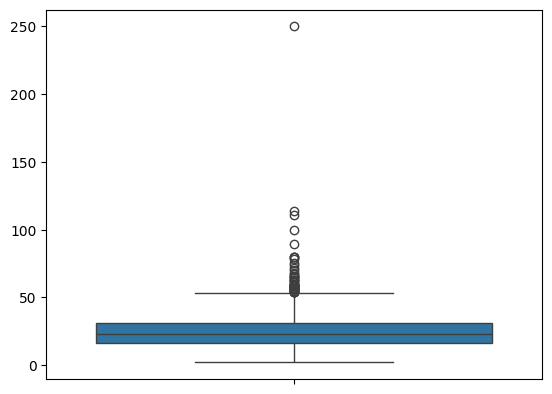

In [110]:
# check length of longest sentence 
lengths = [len(sentence) for sentence in encoded_sentences]
print(max(lengths))
sns.boxplot(lengths)
plt.show()

In [111]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100
X = pad_sequences(encoded_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
print(X[0])
Y = pad_sequences(encoded_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
print(Y[0])
print(len(X[0]))
print(len(Y[0]))

# X_train = pad_sequences(encoded_train_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
# print(X_train[0])
# Y_train = pad_sequences(encoded_train_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
# print(Y_train[0])
# print(len(X_train[0]))
# print(len(Y_train[0]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 5419 3714
    1 2005   78  316    1   39 2383    2  122   22    6 2006  317  444
 2007    3]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  3  7  9  5  6  7 20 12  4  1  2  4  6
  1  3  9  8]
100
100


In [ ]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = ""
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [ ]:
# Glove -> 50, 100, 200, 300
embedding_model = load_embedding_model(embedding_dimension=50)

In [112]:
vocab_size = len(sentence_tokenizer.word_index) + 1
print(vocab_size)
embedding_matrix = np.zeros((vocab_size, 50))

word2id = sentence_tokenizer.word_index

for word, i in tqdm(word2id.items()):
    try:
        embedding_matrix[i, :] = embedding_model[word]
    except KeyError:
        pass

print(embedding_matrix.shape)
print(embedding_matrix[word2id['the']])

10948


100%|██████████| 10947/10947 [00:00<00:00, 353043.30it/s]

(10948, 50)
[ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e-01
 -1.91809997e-01 -1.88230002e+00 -7.67459989e-01  9.90509987e-02
 -4.21249986e-01 -1.95260003e-01  4.00710011e+00 -1.85939997e-01
 -5.22870004e-01 -3.16810012e-01  5.92130003e-04  7.44489999e-03
  1.77780002e-01 -1.58969998e-01  1.20409997e-02 -5.42230010e-02
 -2.98709989e-01 -1.57490000e-01 -3.47579986e-01 -4.56370004e-02
 -4.42510009e-01  1.87849998e-01  2.78489990e-03 -1.84110001e-01
 -1.15139998e-01 -7.85809994e-01]


In [113]:
# For tags use one-hot encoding
from keras.utils import to_categorical

Y = to_categorical(Y)
print(Y.shape)
print(Y[0])

# Y_train = to_categorical(Y_train)
# print(Y_train.shape)
# print(Y_train[0])

(3874, 100, 46)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [118]:
# num words in all sentences
num_words = len(set([word for sentence in all_sentences for word in sentence]))
print(num_words)
num_tags = len(set([tag for sentence in all_tag_sentences for tag in sentence]))
print(num_tags)

10947
45


In [114]:
print(X.shape)
print(Y.shape)

(3874, 100)
(3874, 100, 46)


In [116]:
print("Embeddings shape: {}".format(embedding_matrix.shape))
print("Embedding for 'the': {}".format(embedding_matrix[word2id['the']]))

Embeddings shape: (10948, 50)
Embedding for 'the': [ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e-01
 -1.91809997e-01 -1.88230002e+00 -7.67459989e-01  9.90509987e-02
 -4.21249986e-01 -1.95260003e-01  4.00710011e+00 -1.85939997e-01
 -5.22870004e-01 -3.16810012e-01  5.92130003e-04  7.44489999e-03
  1.77780002e-01 -1.58969998e-01  1.20409997e-02 -5.42230010e-02
 -2.98709989e-01 -1.57490000e-01 -3.47579986e-01 -4.56370004e-02
 -4.42510009e-01  1.87849998e-01  2.78489990e-03 -1.84110001e-01
 -1.15139998e-01 -7.85809994e-01]


In [119]:
# Vocabulary size
print("Vocabulary size: {}".format(vocab_size))

Vocabulary size: 10948


In [120]:
# Split the data into train, val and test sets
X_train = X[0:len(train_sentences)]
Y_train = Y[0:len(train_sentences)]
X_val = X[len(train_sentences):len(train_sentences) + len(val_sentences)]
Y_val = Y[len(train_sentences):len(train_sentences) + len(val_sentences)]
X_test = X[len(train_sentences) + len(val_sentences):]
Y_test = Y[len(train_sentences) + len(val_sentences):]

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1959, 100)
(1959, 100, 46)
(1277, 100)
(1277, 100, 46)
(638, 100)
(638, 100, 46)


In [121]:
# Baseline model: LSTM + FC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, TimeDistributed, Dropout
from keras.optimizers import Adam

num_tags = Y_train.shape[2]

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=MAX_SEQ_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [122]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           547400    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          183296    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 46)           11822     
 ributed)                                                        
                                                                 
Total params: 742518 (2.83 MB)
Trainable params: 195118 (762.18 KB)
Non-trainable params: 547400 (2.09 MB)
_________________________________________________________________


In [123]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=10, verbose=1)

Epoch 1/10
16/16 [==============================] - 19s 807ms/step - loss: 2.7577 - accuracy: 0.7273 - val_loss: 1.0010 - val_accuracy: 0.7751
Epoch 2/10
16/16 [==============================] - 12s 767ms/step - loss: 0.7948 - accuracy: 0.8030 - val_loss: 0.7089 - val_accuracy: 0.8062
Epoch 3/10
16/16 [==============================] - 12s 757ms/step - loss: 0.6666 - accuracy: 0.8192 - val_loss: 0.6432 - val_accuracy: 0.8333
Epoch 4/10
16/16 [==============================] - 12s 782ms/step - loss: 0.6045 - accuracy: 0.8425 - val_loss: 0.5818 - val_accuracy: 0.8509
Epoch 5/10
16/16 [==============================] - 12s 781ms/step - loss: 0.5444 - accuracy: 0.8612 - val_loss: 0.5223 - val_accuracy: 0.8676
Epoch 6/10
16/16 [==============================] - 13s 802ms/step - loss: 0.4863 - accuracy: 0.8758 - val_loss: 0.4674 - val_accuracy: 0.8783
Epoch 7/10
16/16 [==============================] - 13s 799ms/step - loss: 0.4335 - accuracy: 0.8864 - val_loss: 0.4199 - val_accuracy: 0.8908